# Case Study November 7, 2015
This is a case study on observations of a Large-scale Traveling Ionospheric Disturbance (LSTID) over the continential United States on November 7, 2015. The case study uses Resen to access a number of geospace community software pacakges and analyze data from a variety of different instruments.

In [1]:
# some standard imports
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import numpy as np
import datetime as dt
import h5py
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pymap3d as pm

Set the target time for this case study, and create a directory that data will be downloaded to.

In [2]:
targtime = dt.datetime(2015,11,7,2,30,0)

try:
    os.makedirs('/home/jovyan/work/CaseStudyData')
except FileExistsError:
    pass

## MANGO Data
The Midlatitude Allsky-imaging Network for GeoSpace Observations (MANGO) (mango.sri.com) is a network of all-sky cameras deployed around the United States to study upper-atmospheric airglow at 630nm wavelength. Propagating waves in the upper atmosphere can often be seen as enhancements and depletions in the airglow brightness.  MANGO cameras at Hat Creek Observatory and Capitol Reef Field Station show an LSTID with a prominent westward tilt.  LSTIDs are traditionally associated with auroral activity and largely move equatorwards so this seemed like an unusal observation worthy of further investigation!

The `mangopy` package, available at https://github.com/astib/MANGO (but already installed here!), automatically downloads and saves data for requested times to the data directory that was created earlier, so long as that directory is specified when using `mangopy`.

Attempting to download HNov0715.h5 from FTP server.
Sucessfully downloaded HNov0715.h5
Attempting to download CNov0715.h5 from FTP server.
Sucessfully downloaded CNov0715.h5


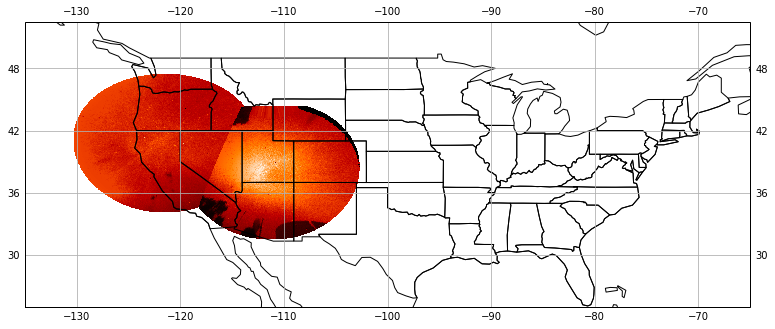

In [3]:
from mangopy import Mosaic

mango_mosaic = Mosaic(sites=['Hat Creek Observatory','Capitol Reef Field Station'],
                      datadir='/home/jovyan/work/CaseStudyData/MANGO/')

# get background grid image and coordinates
img, grid_lat, grid_lon, edge_lat, edge_lon, truetime = mango_mosaic.create_mosaic(targtime, cell_edges=True)

# set up map
fig = plt.figure(figsize=(13,10))
map_proj = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=map_proj)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)
ax.set_extent([225,295,25,47])

# plot image on map
ax.pcolormesh(edge_lon, edge_lat, img, cmap=plt.get_cmap('gist_heat'), transform=ccrs.PlateCarree())


To see how these features progress over time, we'll now create both North-South and East-West keograms of the Capitol Reef Field Station data over the whole night at 110$^\circ$ W.

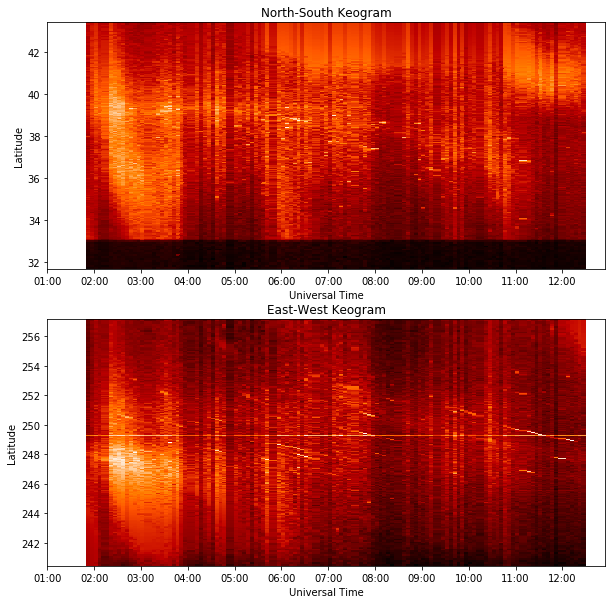

In [4]:
from mangopy import Mango

# initialize a Mango object and the site
mango = Mango(datadir='/home/jovyan/work/CaseStudyData/MANGO/')
crfs = mango.get_site_info('Capitol Reef Field Station')

# read in latitude and longitude arrays for the time shown above
# latitude and longitude do not change with time, so only have to read these once
_, lat, lon, _ = mango.get_data(crfs, targtime)

# find index where center longitude is 110 W, and where center latitude is 38 N
targlon = 360.-110.
targlat = 38.
idx_lat = np.nanargmin(np.abs(lon[int(lon.shape[0]/2),:]-targlon))
idx_lon = np.nanargmin(np.abs(lat[:,int(lat.shape[0]/2)]-targlat))

# get latitude and logitude for keogram
mango_latitude = lat[:,idx_lat]
mango_longitude = lon[idx_lon,:]

# define times for keogram
# this should cover the entire night at 5 minute intervals
mango_times = [dt.datetime(2015,11,7,1,0,0)+dt.timedelta(minutes=m) for m in range(0,720,5)]

# generate keogram array
mango_NS_keogram = np.empty((len(mango_latitude),0))
mango_EW_keogram = np.empty((len(mango_longitude),0))
for t in mango_times:
    try:
        data, _, _, _ = mango.get_data(crfs, t)
    except ValueError:
        data = np.full((len(mango_longitude),len(mango_latitude)), np.nan)
        
    mango_NS_keogram = np.concatenate((mango_NS_keogram,data[:,idx_lat][:,None]),axis=1)
    mango_EW_keogram = np.concatenate((mango_EW_keogram,data[idx_lon,:][:,None]),axis=1)
    
# only plot indicies with finite latitudes
idx_lat = np.argwhere(np.isfinite(mango_latitude)).flatten()
idx_lon = np.argwhere(np.isfinite(mango_longitude)).flatten()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.set_title('North-South Keogram')
ax.pcolormesh(mango_times, mango_latitude[idx_lat], mango_NS_keogram[idx_lat,:],cmap=plt.get_cmap('gist_heat'))
ax.set_xlabel('Universal Time')
ax.set_ylabel('Latitude')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax = fig.add_subplot(212)
ax.set_title('East-West Keogram')
ax.pcolormesh(mango_times, mango_longitude[idx_lon], mango_EW_keogram[idx_lon,:],cmap=plt.get_cmap('gist_heat'))
ax.set_xlabel('Universal Time')
ax.set_ylabel('Latitude')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

Note the south and westward moving form between 2:00 - 3:00 UTC

## Geophysical Parameters
Use spacepy module to check the hourly Interplanetary Magnetic Field and geophysical indicies in the hours around the LSTID observation. 

Text(0.5,0,'Universal Time')

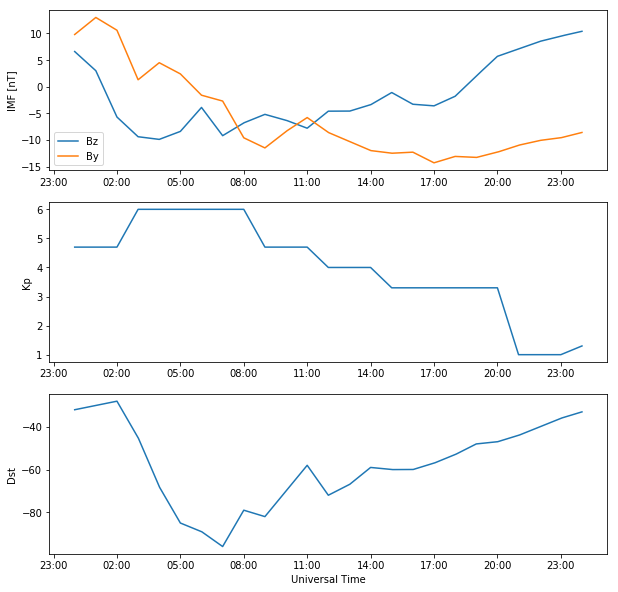

In [5]:
import spacepy.time as spt
import spacepy.omni as om

st = dt.datetime(2015,11,7)
et = dt.datetime(2015,11,8)
ticks = spt.tickrange(st, et, dt.timedelta(minutes=1), 'UTC')
data = om.get_omni(ticks)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,1)

ax = plt.subplot(gs[0])
ax.plot(data['UTC'],data['BzIMF'],label='Bz')
ax.plot(data['UTC'],data['ByIMF'],label='By')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('IMF [nT]')
ax.legend()

ax = plt.subplot(gs[1])
ax.plot(data['UTC'],data['Kp'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('Kp')

ax = plt.subplot(gs[2])
ax.plot(data['UTC'],data['Dst'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('Dst')
ax.set_xlabel('Universal Time')


At 2:30 UTC, the geomagnetic storm is in the main phase, with Kp=6.

## GPS TEC data
For global context, we can look at global maps of Total Electron Content (TEC), which the total electron density integrated vertically as measured by GPS satellites. We can grab this data from [Madrigal](http://cedar.openmadrigal.org/) using the madrigalWeb API. Here we will download the GPS TEC file to the data directory.

In [6]:
import madrigalWeb.madrigalWeb

# ENTER MADRIGAL USER CREDENTIALS HERE
user_fullname = ''
user_email = ''
user_affiliation = ''

madrigalUrl = 'http://cedar.openmadrigal.org'
madrigal = madrigalWeb.madrigalWeb.MadrigalData(madrigalUrl)

madfile = '/opt/madrigal3/experiments3/2015/gps/07nov15/gps151107g.002.hdf5'

try:
    os.makedirs('/home/jovyan/work/CaseStudyData/GPSTEC')
except FileExistsError:
    pass

locfile = os.path.join('/home/jovyan/work/CaseStudyData/GPSTEC',os.path.basename(madfile))

result = madrigal.downloadFile(madfile, locfile, user_fullname, user_email, user_affiliation, 'hdf5')


Read the grid and TEC from the data file.

In [7]:
with h5py.File(locfile,'r') as file:
    tstmp = file['/Data/Array Layout/timestamps'][:]
    tec_latitude = file['/Data/Array Layout/gdlat'][:]
    tec_longitude = file['/Data/Array Layout/glon'][:]
    tec = file['/Data/Array Layout/2D Parameters/tec'][:,:,:]

tec_time = np.array([dt.datetime.utcfromtimestamp(t) for t in tstmp])

Now plot the data for the time specified above.

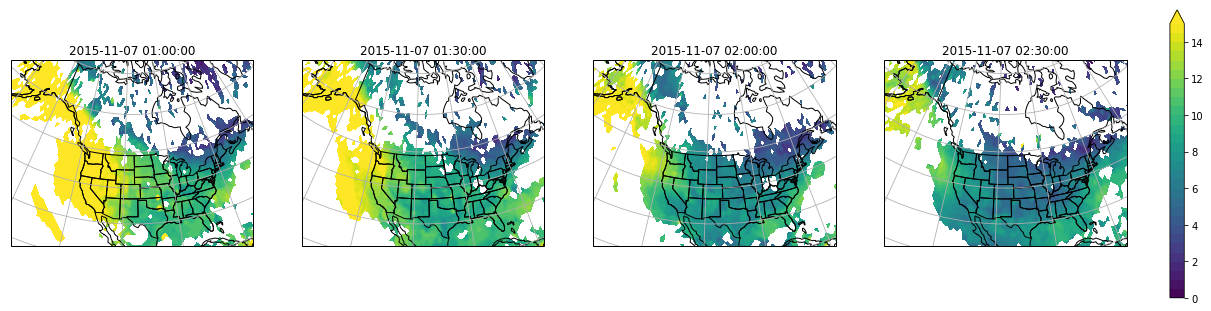

In [8]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,4)
map_proj = ccrs.LambertConformal(central_longitude=255.,central_latitude=40.0)

times = [dt.datetime(2015,11,7,1,0)+dt.timedelta(minutes=m) for m in range(0,120,30)]
for n, time in enumerate(times):

    idx = np.argmin([np.abs((t-time).total_seconds()) for t in tec_time])

    ax = plt.subplot(gs[n],projection=map_proj)
    ax.coastlines()
    ax.gridlines()
    ax.add_feature(cfeature.STATES)
    ax.set_extent([220,290,20,70])
    ax.set_title(time.strftime('%Y-%m-%d %H:%M:%S'))

    c = ax.contourf(tec_longitude, tec_latitude, tec[:,:,idx], np.linspace(0.,15.,31), extend='max', transform=ccrs.PlateCarree())

cax = fig.add_axes([0.93,0.1,0.01,0.8])
plt.colorbar(c,cax=cax)

From this analysis, it is not possible to discern whether the Westward moving TEC enhancement is due to the day-night terminator or something else.

## FPI
Fabry-Perot Interferometers (FPI) can be used to measure the velocity and temperature of the neutral atmosphere. Looking through Madrigal website, we don't find any FPIs in the western United States. But, since LSTIDs are large-scale features, maybe looking at available FPIs in the eastern United States will work. Similar to the TEC data, use the Madrigal API to download the desired FPI data files to the data directory.

In [9]:
fpi_filenames = ['/opt/madrigal3/experiments/2015/kfp/06nov15/kfp151106g.7100.hdf5',
                '/opt/madrigal3/experiments/2015/par/06nov15/minime06_par_20151106.cedar.003.hdf5',
                '/opt/madrigal3/experiments/2015/uao/06nov15/minime05_uao_20151106.cedar.002.hdf5',
                '/opt/madrigal3/experiments/2015/ann/06nov15/minime08_ann_20151106.cedar.003.hdf5']

try:
    os.makedirs('/home/jovyan/work/CaseStudyData/FPI')
except FileExistsError:
    pass

for madfile in fpi_filenames:

    locfile = os.path.join('/home/jovyan/work/CaseStudyData/FPI',os.path.basename(madfile))
    result = madrigal.downloadFile(madfile, locfile, user_fullname, user_email, user_affiliation, 'hdf5')


Map the locations of the different FPIs.

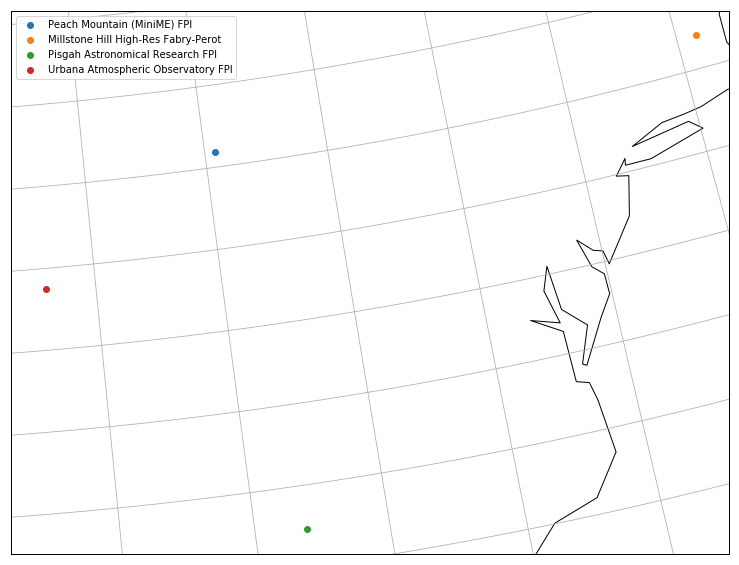

In [10]:
fpi_dir = '/home/jovyan/work/CaseStudyData/FPI'

sites = {}
for fn in os.listdir(fpi_dir):
    with h5py.File(os.path.join(fpi_dir,fn), 'r') as f:
        instrument = f['/Metadata/Experiment Parameters']['value'][0].decode('UTF-8')
        site = f['/Metadata/Experiment Parameters']['value'][8:11]
        sites[instrument] = site
    
fig = plt.figure(figsize=(13,10))
map_proj = ccrs.LambertConformal()
ax = fig.add_subplot(111,projection=map_proj)
ax.coastlines()
ax.gridlines()

for inst in sites.keys():
    ax.scatter(float(sites[inst][1]),float(sites[inst][0]), label=inst, transform=ccrs.Geodetic())
ax.legend()

From the map, we can see that most FPIs are concentrated in the south-eastern United States.

Now let's look at time series data for the FPI neutral winds:

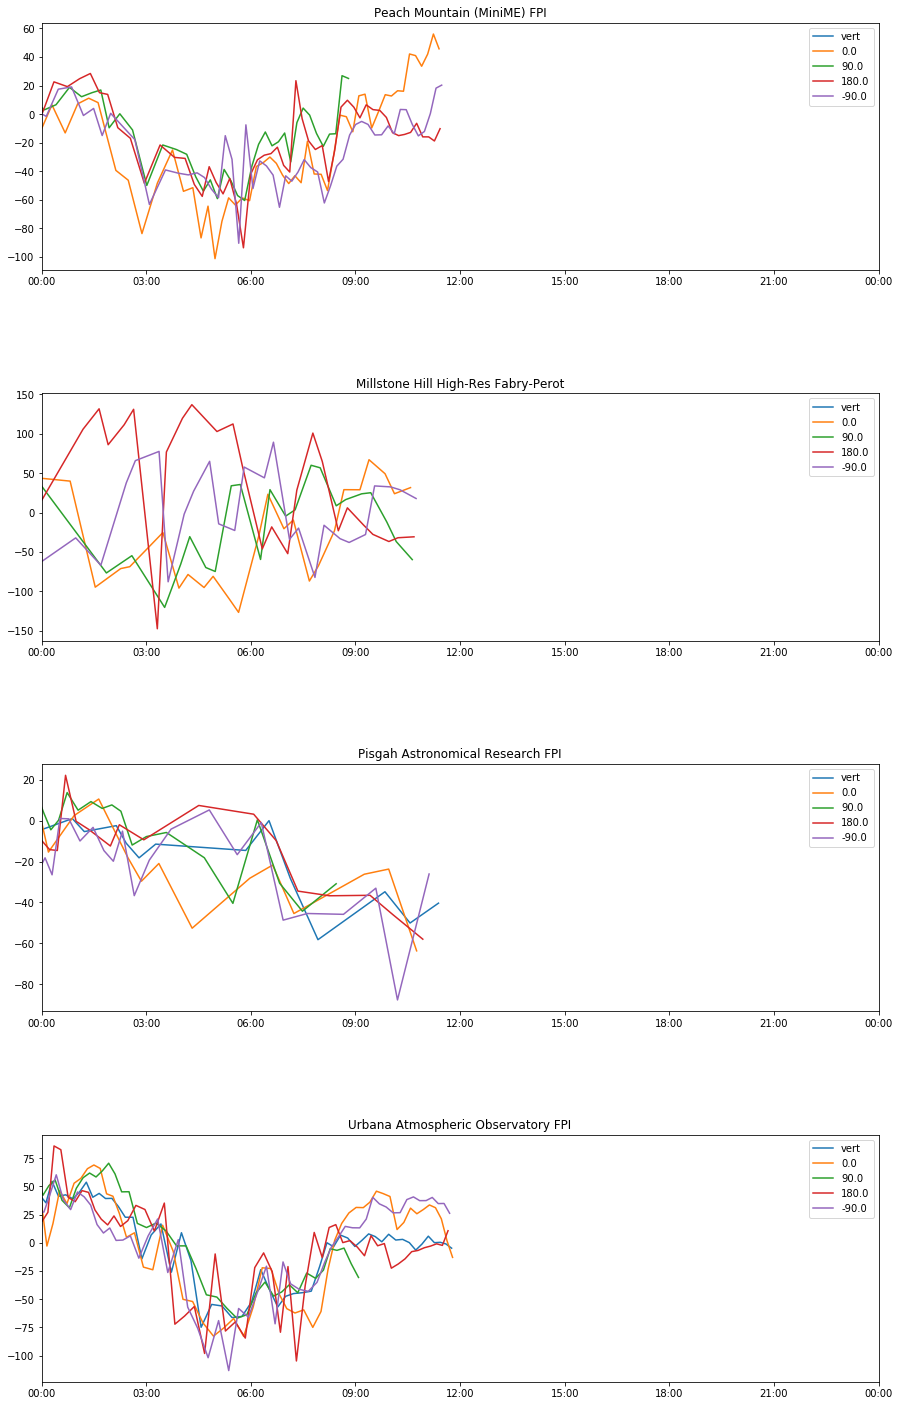

In [11]:
fig = plt.figure(figsize=(15,25))
gs = gridspec.GridSpec(len(os.listdir(fpi_dir)),1)
gs.update(hspace=0.5)

for n, fn in enumerate(os.listdir(fpi_dir)):

    with h5py.File(os.path.join(fpi_dir,fn), 'r') as f:

        instrument = f['/Metadata/Experiment Parameters']['value'][0].decode('UTF-8')
        stime = f['/Data/Table Layout']['ut1_unix'][:]
        etime = f['/Data/Table Layout']['ut2_unix'][:]
        az = f['/Data/Table Layout']['azm'][:]
        el = f['/Data/Table Layout']['elm'][:]
        tn = f['/Data/Table Layout']['tn'][:]
#         print(f['/Data/Table Layout'].keys())
        try:
            vn = f['/Data/Table Layout']['vnu'][:]
        except ValueError:
            vn = f['/Data/Table Layout']['vnhlu'][:]

    tstmp = np.array([dt.datetime.utcfromtimestamp((st+et)/2.) for st, et in zip(stime, etime)])

    idx = np.argwhere((az==0.) & (el==90.)).flatten()
    time = {'vert':tstmp[idx]}
    Tn = {'vert':tn[idx]}
    Vn = {'vert':vn[idx]}

    for az0 in [0., 90., 180., -90.]:
        idx = np.argwhere((az==az0) & (el==45.)).flatten()
        time[str(az0)] = tstmp[idx]
        Tn[str(az0)] = tn[idx]
        Vn[str(az0)] = vn[idx]

    ax = plt.subplot(gs[n])

    for k in time.keys():
        ax.plot(time[k], Vn[k], label=k)
    ax.set_xlim([dt.datetime(2015,11,7),dt.datetime(2015,11,8)])
    ax.set_title(instrument)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.legend()

From the above figures, the Millstone Hill FPI data seem to have large inconsistent variations, which requires investigation. However, the remaining FPIs show consistent south-westward winds, which seems to agree with the MANGO all sky camera observations in the Western United states, with the caveat that the MANGO cameras and FPIs are separated by $\approx$40$^\circ$ of longitude. 

## Conclusions
We looked at an interesting event observed in one instrument data and performed subsequent analysis using data from a couple of other types of instruments. More data sources, such as SuperDARN data and/or SuperMAG data could also be added to this analysis to help understand what was happening with background plasma drift velocities and substorm activity in the high-latitudes. A more complete case study has recently been published in the Journal of Space Weather and Space Climate, which shows that adding other data sources makes it clear that the propagation direction of the LSTID is highly correlated with the expansion of geomagnetic storm activity from high-latitudes to lower latitudes. 

And Resen has simplified the analysis process and helped us! All while using open-source tools!